In [39]:
import pandas as pd
import re
import spacy
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multiclass import OneVsOneClassifier
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 100)

In [3]:
tqdm.pandas()
nlp = spacy.load('en_core_web_sm')

C:\Users\ramya\AppData\Local\Continuum\anaconda3\lib\site-packages\tqdm\std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
df = pd.read_csv('data/hatespeech_text_label_vote_RESTRICTED_100K.csv', header=None, sep='\t')
df.columns = ['text', 'label', 'votes']

In [15]:
df.groupby(['label']).size().reset_index(name='counts')

,label,counts
0,abusive,27150
1,hateful,4965
2,normal,53851
3,spam,14030


In [10]:
def clean(text):
    text = re.sub(r'\w*@\w*\.\w*', '', text)  # remove emails
    text = re.sub(r'#.+?(\s|$)', '', text)  # remove hashtags
    text = re.sub(r'(https{0,1}\:\/\/.+?(\s|$))|(www\..+?(\s|$))|('
                  r'\b\w+\.twitter\.com.+?(\s|$))', ' ',
                  text)  # remove urls
    text = re.sub(r'(@.+?(\b|\s|$))', '', text)  # remove mentions
    text = re.sub(r'\b(RT|rt)\b', '', text)  # remove retweets
    text = re.sub(r'(&#\w+;)+', ' ', text)  # &amp;
    text = re.sub(r'(&amp;)+', ' ', text)
    text = re.sub(r'(\\n)+', ' ', text)  # remove \n
    text = re.sub(r'(\[deleted\])|(\[removed\])', ' ',
                  text)  # remove [deleted] and [removed]
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    return text

def lemmatize(sentence):
    doc = nlp(sentence)
    return " ".join([token.lemma_ for token in doc])

In [11]:
df['cleaned'] = df['text'].progress_apply(lambda x : clean(x))
df['lemmatized'] = df['cleaned'].progress_apply(lambda x: lemmatize(x))
df.to_pickle('data/processed.pkl')

100%|███████████████████████████████████████████████████████████████████████████| 99996/99996 [12:19<00:00, 135.14it/s]


In [17]:
df.iloc[0]

text          Beats by Dr. Dre urBeats Wired In-Ear Headphones - White https://t.co/9tREpqfyW4 https://t.co/FCaWyWRbpE
label         1                                                                                                       
votes         4                                                                                                       
cleaned       beats by dr. dre urbeats wired in-ear headphones - white                                                
lemmatized    beat by dr . dre urbeats wire in - ear headphone - white                                                
Name: 0, dtype: object

In [4]:
with open('data/processed.pkl', 'rb') as f:
    df = pickle.load(f)

In [5]:
def assign_label(x):
    if x == 'normal':
        return 0
    elif x == 'spam':
        return 1
    elif x == 'abusive':
        return 2
    else:
        return 3

In [6]:
df['label'] = df['label'].apply(lambda x : assign_label(x))

In [19]:
ngram_vectorizer = CountVectorizer(input='content',
                                   analyzer='word',
                                   strip_accents='ascii',
                                   ngram_range=(1,3),
                                   min_df=2)

In [7]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [20]:
trainX = ngram_vectorizer.fit_transform(train_df['lemmatized'])
trainY = train_df['label']

In [21]:
classifier = OneVsOneClassifier(svm.LinearSVC(class_weight='balanced', C=0.1, max_iter=2000), n_jobs=-1)

In [22]:
classifier.fit(trainX, trainY)

OneVsOneClassifier(estimator=LinearSVC(C=0.1, class_weight='balanced',
                                       dual=True, fit_intercept=True,
                                       intercept_scaling=1,
                                       loss='squared_hinge', max_iter=2000,
                                       multi_class='ovr', penalty='l2',
                                       random_state=None, tol=0.0001,
                                       verbose=0),
                   n_jobs=-1)

In [23]:
predY = classifier.predict(trainX)

In [24]:
print(classification_report(trainY, predY))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     43003
           1       0.78      0.97      0.86     11213
           2       0.97      0.96      0.96     21781
           3       0.82      0.97      0.89      3999

    accuracy                           0.94     79996
   macro avg       0.89      0.95      0.92     79996
weighted avg       0.95      0.94      0.94     79996



In [25]:
testX = ngram_vectorizer.transform(test_df['lemmatized'])

In [26]:
predY = classifier.predict(testX)

In [12]:
testY = test_df['label']

In [28]:
print(classification_report(testY, predY))

              precision    recall  f1-score   support

           0       0.85      0.80      0.83     10848
           1       0.49      0.62      0.54      2817
           2       0.88      0.86      0.87      5369
           3       0.40      0.39      0.40       966

    accuracy                           0.77     20000
   macro avg       0.65      0.67      0.66     20000
weighted avg       0.79      0.77      0.78     20000



In [29]:
train_df.groupby('label').size().reset_index(name='counts')['counts']/79996

0    0.537564
1    0.140170
2    0.272276
3    0.049990
Name: counts, dtype: float64

In [30]:
test_df.groupby('label').size().reset_index(name='counts')['counts']/20000

0    0.54240
1    0.14085
2    0.26845
3    0.04830
Name: counts, dtype: float64

In [64]:
test_df.shape

(20000, 5)

In [57]:
bow_vectorizer = CountVectorizer(input='content',
                                 analyzer='word',
                                 strip_accents='ascii',
                                 ngram_range=(1,3),
                                 stop_words='english',
                                 min_df=10)

In [58]:
df = pickle.load(open('data/processed.pkl', 'rb'))

In [59]:
df_abusive = df[df['label'] == 'abusive']

In [69]:
df_abusive['cleaned'] = df_abusive['text'].apply(lambda x : clean(x))
df_abusive['lemmatized'] = df_abusive['cleaned'].apply(lambda x: lemmatize(x))

/Users/sanjana/anaconda3/envs/west/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/sanjana/anaconda3/envs/west/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [74]:
bow_vectorizer = CountVectorizer(input='content',
                                 analyzer='word',
                                 strip_accents='ascii',
                                 ngram_range=(2,5),
                                 stop_words='english',
                                 min_df=10)
X = bow_vectorizer.fit_transform(df_abusive['lemmatized'])

In [75]:
feature_names = np.array(bow_vectorizer.get_feature_names())
feature_names[np.argsort(np.array(X.sum(axis=0))[0])[::-1]][:50].tolist()

['ugly ass',
 'bad bitch',
 'ass bitch',
 'feel like',
 'know fucking',
 'bitch like',
 'wanna fuck',
 'just fucking',
 'oh god',
 'look like',
 'stop fuck',
 'fucking hate',
 'fucking george',
 'george bush',
 'know fucking george',
 'know fucking george bush racist',
 'fucking george bush racist',
 'fucking george bush',
 'george bush racist',
 'bush racist',
 'know fucking george bush',
 'sorry ugly',
 'ugly ass bitch',
 'sweetie sorry',
 'sorry ugly ass',
 'stupid ass',
 'sorry ugly ass bitch',
 'like say',
 'damn phone',
 'ass bitch like',
 'look fucking',
 'like fucking',
 'just fuck',
 'sorry ugly ass bitch like',
 'say oh',
 'ugly ass bitch like',
 'bitch like say',
 'say oh god',
 'like say oh',
 'know fuck',
 'fucking bad',
 'bitch like say oh',
 'like say oh god',
 'fucking thing',
 'bitch like say oh god',
 'ugly ass bitch like say',
 'fucking hell',
 'ass bitch like say',
 'sick damn',
 'say sick']

In [8]:
tfidf_vectorizer = TfidfVectorizer(input='content',
                                   analyzer='word',
                                   strip_accents='ascii',
                                   ngram_range=(1,3),
                                   min_df=5,
                                   stop_words='english',
                                   use_idf = True)

In [9]:
trainX = tfidf_vectorizer.fit_transform(train_df['lemmatized'])
testX = tfidf_vectorizer.transform(test_df['lemmatized'])

In [37]:
features = tfidf_vectorizer.get_feature_names()
len(features)

27516

In [38]:
rf_classifier = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 42) #entropy
rf_classifier.fit(trainX, trainY)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [40]:
predY = rf_classifier.predict(trainX)
print(classification_report(trainY, predY))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     43003
           1       0.96      0.93      0.94     11213
           2       0.97      0.99      0.98     21781
           3       0.96      0.90      0.93      3999

    accuracy                           0.97     79996
   macro avg       0.97      0.95      0.96     79996
weighted avg       0.97      0.97      0.97     79996



In [41]:
predY = rf_classifier.predict(testX)
print(classification_report(testY, predY))

              precision    recall  f1-score   support

           0       0.80      0.92      0.85     10848
           1       0.58      0.29      0.39      2817
           2       0.85      0.91      0.88      5369
           3       0.61      0.21      0.31       966

    accuracy                           0.79     20000
   macro avg       0.71      0.58      0.61     20000
weighted avg       0.77      0.79      0.77     20000



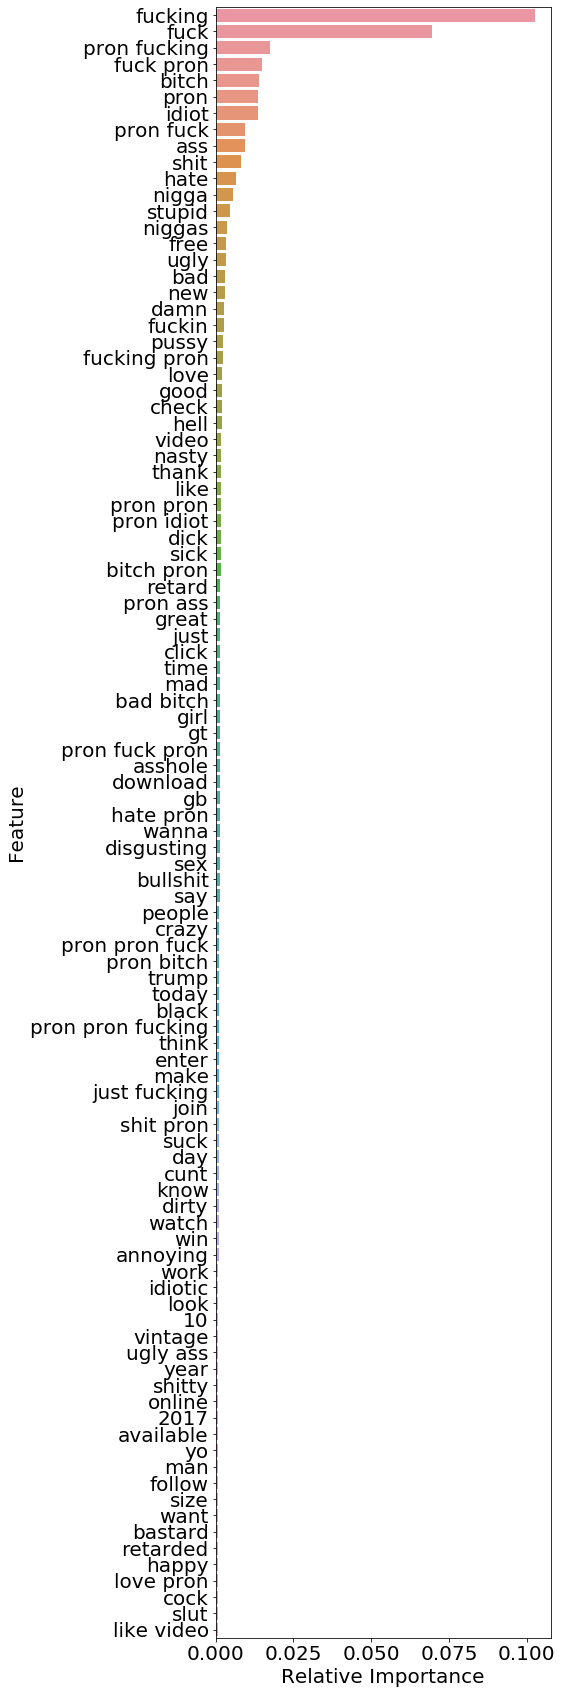

In [52]:
rf_imps = rf_classifier.feature_importances_
sort_ind = np.argsort(rf_imps)
top_n = sort_ind[::-1][:100]
sorted_imps = rf_imps[top_n]
top_feats = np.array(features)[top_n]

plt.figure(figsize=(6, 30))
plt.xlabel('Relative Importance', fontsize=20)
plt.ylabel('Feature', fontsize=20)
sns.barplot(y = top_feats, x = sorted_imps)
plt.tick_params(labelsize=20)
plt.show()

In [47]:
np.array(features)[top_n]

array(['fucking', 'fuck', 'pron fucking', 'fuck pron', 'bitch', 'pron',
       'idiot', 'pron fuck', 'ass', 'shit'], dtype='<U36')

In [31]:
lr_classifier = OneVsOneClassifier(LogisticRegression(class_weight='balanced', C=1, max_iter=7000), n_jobs=-1)
lr_classifier.fit(trainX, trainY)

OneVsOneClassifier(estimator=LogisticRegression(C=1, class_weight='balanced',
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=7000,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='warn', tol=0.0001,
                                                verbose=0, warm_start=False),
                   n_jobs=-1)

In [32]:
predY = lr_classifier.predict(trainX)
print(classification_report(trainY, predY))

              precision    recall  f1-score   support

           0       0.93      0.77      0.84     43003
           1       0.53      0.81      0.64     11213
           2       0.92      0.85      0.88     21781
           3       0.46      0.82      0.59      3999

    accuracy                           0.80     79996
   macro avg       0.71      0.81      0.74     79996
weighted avg       0.85      0.80      0.81     79996



In [33]:
predY = lr_classifier.predict(testX)
print(classification_report(testY, predY))

              precision    recall  f1-score   support

           0       0.87      0.73      0.80     10848
           1       0.46      0.70      0.55      2817
           2       0.90      0.82      0.86      5369
           3       0.32      0.56      0.41       966

    accuracy                           0.74     20000
   macro avg       0.64      0.70      0.65     20000
weighted avg       0.79      0.74      0.76     20000

